In [76]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go
import chart_studio.plotly as py
import matplotlib.pyplot as plt

# for web crawling 
import pandas_datareader.data as web
import datetime

# import ols
from statsmodels.formula.api import ols
from statsmodels.formula.api import gls


## Exchange Rate Scrapping

In [145]:
# target web to crawl 
target = "xxxx"
# Define the time period
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2023, 3, 1)

In [147]:
# get EURO-US exchange rate data from 2000-01-01 to 2022-1-1

df_eu = yf.download('EURUSD=X', start=start_date, end=end_date, progress=False)
df_eu = df_eu.reset_index()
df_eu = df_eu[['Date', 'Close']]
df_eu.columns = ['Date', 'EURUSD']

# change the frequency of the data to monthly
df_eu = df_eu.set_index('Date')
df_eu = df_eu.resample('M').mean()
df_eu = df_eu.reset_index()

# get rid of the days in the date column
df_eu['Date'] = df_eu['Date'].dt.strftime('%Y-%m')
# rename Date to date
df_eu = df_eu.rename(columns={'Date': 'date'})
df_eu.tail()


,date,EURUSD
226,2022-10,0.983970
227,2022-11,1.018547
228,2022-12,1.058271
229,2023-01,1.077561
230,2023-02,1.071893


In [148]:
# get AUD-US exchange rate data from 2000-01-01 to 2022-1-1

df_aud = yf.download('AUDUSD=X', start=start_date, end=end_date, progress=False)
df_aud = df_aud.reset_index()
df_aud = df_aud[['Date', 'Close']]
df_aud.columns = ['Date', 'AUDUSD']

# change the frequency of the data to monthly
df_aud = df_aud.set_index('Date')
df_aud = df_aud.resample('M').mean()
df_aud = df_aud.reset_index()

# get rid of the days in the date column
df_aud['Date'] = df_aud['Date'].dt.strftime('%Y-%m')
# rename Date to date
df_aud.columns = ['date', 'AUDUSD']
df_aud.head()


,date,AUDUSD
0,2006-05,0.758151
1,2006-06,0.739926
2,2006-07,0.752416
3,2006-08,0.763157
4,2006-09,0.755768


In [149]:
# get argentina-US exchange rate data from 2000-01-01 to 2022-1-1

df_ars = yf.download('ARS=X',start=start_date, end=end_date, progress=False)
df_ars = df_ars.reset_index()
df_ars = df_ars[['Date', 'Close']]
df_ars.columns = ['Date', 'ARSUSD']

# change the frequency of the data to monthly
df_ars = df_ars.set_index('Date')
df_ars = df_ars.resample('M').mean()
df_ars = df_ars.reset_index()

# get rid of the days in the date column
df_ars['Date'] = df_ars['Date'].dt.strftime('%Y-%m')
# rename Date to date
df_ars = df_ars.rename(columns={'Date': 'date'})
df_ars.head()


,date,ARSUSD
0,2001-07,0.998775
1,2001-08,0.998737
2,2001-09,0.998450
3,2001-10,NaN
4,2001-11,NaN


In [150]:
# get japan-US exchange rate data from 2000-01-01 to 2022-1-1

df_jpy = yf.download('JPY=X', start=start_date, end=end_date, progress=False)
df_jpy = df_jpy.reset_index()
df_jpy = df_jpy[['Date', 'Close']]
df_jpy.columns = ['Date', 'JPYUSD']

# change the frequency of the data to monthly
df_jpy = df_jpy.set_index('Date')
df_jpy = df_jpy.resample('M').mean()
df_jpy = df_jpy.reset_index()

# get rid of the days in the date column
df_jpy['Date'] = df_jpy['Date'].dt.strftime('%Y-%m')
# rename Date to date
df_jpy = df_jpy.rename(columns={'Date': 'date'})
df_jpy.head()

,date,JPYUSD
0,2000-01,105.260000
1,2000-02,109.451429
2,2000-03,106.342174
3,2000-04,105.641000
4,2000-05,108.126522


In [151]:
# get China-US exchange rate data from 2000-01-01 to 2022-1-1
df = yf.download("CNY=X",start=start_date, end=end_date)
df = df.reset_index()
df = df.rename(columns={"Date": "date", "Close": "cny_usd"})
df.head()

# change the frequency of the data from daily to monthly
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()
# change to monthly frequency, only include the month not the day
df = df.resample('M').mean()
df = df.reset_index()
df.head()

# get rid of the day in the date column
df['date'] = df['date'].dt.strftime('%Y-%m')
#only keep close price
df_china = df[['date', 'cny_usd']]
# rename the cny_usd column to CNYUSD
df_china = df_china.rename(columns={'cny_usd': 'CNYUSD'})


df_china.head()


[*********************100%***********************]  1 of 1 completed


,date,CNYUSD
0,2001-06,8.276800
1,2001-07,8.276814
2,2001-08,8.276969
3,2001-09,8.276850
4,2001-10,8.276842


In [152]:
# pound sterling-US exchange rate data from 2000-01-01 to 2022-1-1

df_gbp = yf.download('GBPUSD=X', start=start_date, end=end_date, progress=False)
df_gbp = df_gbp.reset_index()
df_gbp = df_gbp[['Date', 'Close']]
df_gbp.columns = ['Date', 'GBPUSD']

# change the frequency of the data to monthly
df_gbp = df_gbp.set_index('Date')
df_gbp = df_gbp.resample('M').mean()
df_gbp = df_gbp.reset_index()

# get rid of the days in the date column
df_gbp['Date'] = df_gbp['Date'].dt.strftime('%Y-%m')
# rename Date to date
df_gbp = df_gbp.rename(columns={'Date': 'date'})
df_gbp.head()


,date,GBPUSD
0,2003-12,1.753903
1,2004-01,1.821047
2,2004-02,1.869247
3,2004-03,1.828007
4,2004-04,1.804626


## Variables of Interest

### Trade Balance

In [153]:
# Get the trade balance data for the US
df_trade = web.DataReader('BOPGSTB', 'fred', start_date, end_date)
# get rid of the day in the date column
df_trade['date'] = df_trade.index.strftime('%Y-%m')
df_trade = df_trade.reset_index(drop=True)
df_trade.head()
# rename the column
df_trade = df_trade.rename(columns={'BOPGSTB': 'trade_bal'})

### Interest Rate

In [154]:
# Get the interest rate data for the US
df_interest = web.DataReader('DFF', 'fred', start_date, end_date)
# get rid of the day in the date column
df_interest['date'] = df_interest.index.strftime('%Y-%m')
df_interest = df_interest.reset_index(drop=True)
df_interest.tail()


,DFF,date
8456,4.58,2023-02
8457,4.58,2023-02
8458,4.57,2023-02
8459,4.57,2023-02
8460,4.58,2023-03


### Output

In [155]:
# get the real gdp data for the US
df_gdp = web.DataReader('GDPC1', 'fred', start_date, end_date)
# get rid of the day in the date column
df_gdp['date'] = df_gdp.index.strftime('%Y-%m')
df_gdp = df_gdp.reset_index(drop=True)
df_gdp.head()


,GDPC1,date
0,12935.252,2000-01
1,13170.749,2000-04
2,13183.890,2000-07
3,13262.250,2000-10
4,13219.251,2001-01


### Sentiments

In [156]:
# Get the trade balance data for the US
df_sentiment  = web.DataReader('UMCSENT', 'fred', start_date, end_date)
# get rid of the day in the date column
df_sentiment['DATE'] = df_sentiment.index.strftime('%Y-%m')
df_sentiment = df_sentiment.reset_index(drop=True)
# rename Date to date
df_sentiment = df_sentiment.rename(columns={'DATE': 'date'})
df_sentiment.head()

,UMCSENT,date
0,112.0,2000-01
1,111.3,2000-02
2,107.1,2000-03
3,109.2,2000-04
4,110.7,2000-05


In [157]:
# merge the two dataframes
df_final = pd.merge(df_sentiment, df_china, how='left', left_on="date", right_on='date')
df_final = pd.merge(df_final, df_eu, how='left', left_on="date", right_on='date')
df_final = pd.merge(df_trade, df_final, how='left', left_on="date", right_on='date')
# merge the third dataframe
#df_final = pd.merge(df_final, df_eu, how='right', left_on="DATE", right_on='Date')
# change eursd to 1/eurusd
#df_final['EURUSD'] = 1/df_final['EURUSD']
df_final.tail()

,trade_bal,date,UMCSENT,CNYUSD,EURUSD
272,-72638.0,2022-09,58.6,7.005973,0.991166
273,-77161.0,2022-10,59.9,7.182876,0.983970
274,-60646.0,2022-11,56.8,7.181300,1.018547
275,-67210.0,2022-12,59.7,6.980082,1.058271
276,-68289.0,2023-01,64.9,6.797468,1.077561


## Simple OLS

In [158]:
# analyze the data
df_final.describe()
model = ols("CNYUSD ~ UMCSENT", data=df_final).fit()
# print the model result nicely
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 CNYUSD   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     20.13
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           1.10e-05
Time:                        23:47:35   Log-Likelihood:                -272.05
No. Observations:                 253   AIC:                             548.1
Df Residuals:                     251   BIC:                             555.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6848      0.301     18.909      0.0

In [159]:
# now for EURUSD
# corr = df_final["EURUSD"].corr(df_final["gdp_growth"])
model = ols("EURUSD ~ UMCSENT", data=df_final).fit()
# print the model result nicely
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 EURUSD   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     36.50
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           6.16e-09
Time:                        23:47:35   Log-Likelihood:                 169.22
No. Observations:                 230   AIC:                            -334.4
Df Residuals:                     228   BIC:                            -327.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5420      0.050     31.008      0.0

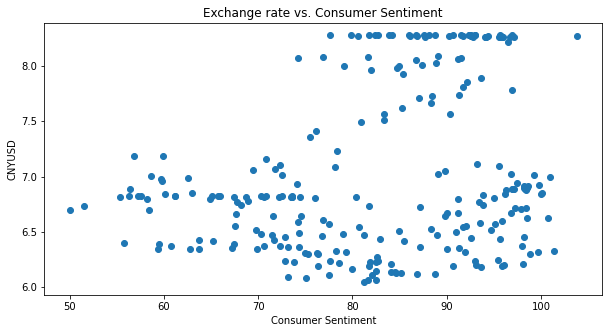

In [160]:
# visualize the data
# use a graph object
plt.scatter(df_final["UMCSENT"], df_final["CNYUSD"])
plt.title("Exchange rate vs. Consumer Sentiment")
plt.xlabel("Consumer Sentiment")
plt.ylabel("CNYUSD")

# resize the graph
plt.rcParams["figure.figsize"] = (10, 5)



## SUR Model Data Preparation 

In [201]:
# merge df_china and df_eu
df_sur1 = pd.merge(df_china, df_eu, how='left', left_on="date", right_on='date')

In [202]:
# add a column callded china to df_china
df_china['country'] = "China"
# add a column called euro to df_eu
df_eu['country'] = "Europe"
# renaqme Date to date
df_eu = df_eu.rename(columns={'Date': 'DATE'})
# merge df_UMCSENT and df_eu, on date
df_sur2 = pd.concat([df_china, df_eu], axis=0)
# create a column called value, which is the value of the exchange rate of the country
# fill na of EURUSD with CNYUSD if the country is China
df_sur2['value'] = np.where(df_sur2['country'] == "China", df_sur2['CNYUSD'], df_sur2['EURUSD'])
# drop CNYUSD and EURUSD
df_sur2 = df_sur2.drop(['CNYUSD', 'EURUSD'], axis=1)


# now for japan
df_jpy['country'] = "Japan"
# Britain
df_gbp['country'] = "Britain"
# australia
df_aud['country'] = "Australia"


# concat df_japan and df_argentina
df_sur3 = pd.concat([df_jpy, df_gbp, df_aud], axis=0)

# create a column called value, which is the value of the exchange rate of the country
# fill na for all three countries values with JPYUSD if the country is Japan, ARSUSD if Argentina, AUDUSD if Australia
df_sur3['value'] = np.where(df_sur3['country'] == "Japan", df_sur3['JPYUSD'], df_sur3['GBPUSD'])
df_sur3['value'] = np.where(df_sur3['country'] == "Australia", df_sur3['AUDUSD'], df_sur3['value'])
df_sur3 = df_sur3.drop(['JPYUSD', 'GBPUSD', 'AUDUSD'], axis=1)

# now merge df_sur2 and df_sur3
df_sur4 = pd.concat([df_sur2, df_sur3], axis=0)



# now merge with df_sentiment on date
# trade balance
df_sur5 = pd.merge(df_sentiment, df_trade, how='left', left_on="date", right_on='date')
# interest rate
df_sur5 = pd.merge(df_sur5, df_interest, how='left', left_on="date", right_on='date')
# gdp
df_sur5 = pd.merge(df_sur5, df_gdp, how='left', left_on="date", right_on='date')

## For more variables, add them here!!

# merge df_sur4 and df_sur5
df_sur6 = pd.merge(df_sur4, df_sur5, how='left', left_on="date", right_on='date')

df_sur6.rename(columns={'value': 'Forex'}, inplace=True)
df_sur6.set_index('date', inplace=True)

In [203]:
df_sur6

,date,country,value,UMCSENT,trade_bal,DFF,GDPC1
0,2001-06,China,8.276800,92.6,-29151.0,4.14,NaN
1,2001-06,China,8.276800,92.6,-29151.0,4.14,NaN
2,2001-06,China,8.276800,92.6,-29151.0,4.14,NaN
3,2001-06,China,8.276800,92.6,-29151.0,4.03,NaN
4,2001-06,China,8.276800,92.6,-29151.0,3.93,NaN
...,...,...,...,...,...,...,...
36471,2023-01,Australia,0.694328,64.9,-68289.0,4.33,NaN
36472,2023-01,Australia,0.694328,64.9,-68289.0,4.33,NaN
36473,2023-01,Australia,0.694328,64.9,-68289.0,4.33,NaN
36474,2023-01,Australia,0.694328,64.9,-68289.0,4.33,NaN


In [205]:
# check for missing values
df_sur6.isnull().sum()

country          0
Forex          214
UMCSENT          5
trade_bal        5
DFF              5
GDPC1        24298
dtype: int64

In [206]:
# drop the missing values
df_sur6 = df_sur6.dropna()

In [207]:
df_sur6

,country,Forex,UMCSENT,trade_bal,DFF,GDPC1
date,,,,,,
2001-07,China,8.276814,92.4,-29902.0,3.95,13248.142
2001-07,China,8.276814,92.4,-29902.0,4.11,13248.142
2001-07,China,8.276814,92.4,-29902.0,3.69,13248.142
2001-07,China,8.276814,92.4,-29902.0,3.69,13248.142
2001-07,China,8.276814,92.4,-29902.0,3.72,13248.142
...,...,...,...,...,...,...
2022-10,Australia,0.636590,59.9,-77161.0,3.08,20187.495
2022-10,Australia,0.636590,59.9,-77161.0,3.08,20187.495
2022-10,Australia,0.636590,59.9,-77161.0,3.08,20187.495


In [210]:
# for each date and country, get the mean of the forex, trade balance, interest rate, and gdp
df_sur7 = df_sur6.groupby(['date', 'country']).mean()
# reset the index
df_sur7 = df_sur7.reset_index()

In [211]:
df_sur7

,date,country,Forex,UMCSENT,trade_bal,DFF,GDPC1
0,2000-01,Japan,105.260000,112.0,-27131.0,5.448387,12935.252
1,2000-04,Japan,105.641000,109.2,-28598.0,6.019667,13170.749
2,2000-07,Japan,107.988571,108.3,-31252.0,6.544516,13183.890
3,2000-10,Japan,108.366364,105.8,-33378.0,6.509355,13262.250
4,2001-01,Japan,116.797826,94.7,-35202.0,5.975806,13219.251
...,...,...,...,...,...,...,...
389,2022-10,Australia,0.636590,59.9,-77161.0,3.080000,20187.495
390,2022-10,Britain,1.129808,59.9,-77161.0,3.080000,20187.495
391,2022-10,China,7.182876,59.9,-77161.0,3.080000,20187.495
392,2022-10,Europe,0.983970,59.9,-77161.0,3.080000,20187.495


## Output For R Analysis

In [213]:
# df_sur7.to_excel("df_sur_forecast.xlsx")